# This notebook demonstrates plotting seaonal mean MCS rain and track statistics on maps
## The monthly data is produced by: 
* /Analysis/calc_tbpf_mcs_monthly_rainmap.py
* /Analysis/calc_tbpf_mcs_monthly_statsmap.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import colorcet as cc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import chain
import copy
%matplotlib inline

In [2]:
# Sepcify directory of the MCS track stats file
rootdir = '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/'
gpmdir = f'{rootdir}GPM/stats/monthly/'
wrfdir = f'{rootdir}WRF/stats/monthly/'

start_year = 2018
end_year = 2019
# start_year = 2015
# end_year = 2016
# start_year = 2010
# end_year = 2011
# start_year = 2010
# end_year = 2019

# Create a list of dates in the format 'year-months'
dates = []
for iy in range(start_year, end_year+1, 1):
    dates = dates + [d.strftime('%Y%m') for d in pd.date_range(start=f'{iy}-01', end=f'{iy}-12', freq='MS')]

# Find all files from the list of dates
wrffiles = []
gpmfiles = []
wrfstatsfiles = []
gpmstatsfiles = []
for dd in dates:
    wrffiles = wrffiles + sorted(glob.glob(f'{wrfdir}mcs_rainmap_{dd}*.nc'))
    gpmfiles = gpmfiles + sorted(glob.glob(f'{gpmdir}mcs_rainmap_{dd}*.nc'))
    wrfstatsfiles = wrfstatsfiles + sorted(glob.glob(f'{wrfdir}mcs_statsmap_{dd}*.nc'))
    gpmstatsfiles = gpmstatsfiles + sorted(glob.glob(f'{gpmdir}mcs_statsmap_{dd}*.nc'))

nyears_gpm = 1
nyears_wrf = 1
    
# topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

figdir = f'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/


In [3]:
gpmfiles, gpmstatsfiles

(['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201806.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201807.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201808.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201809.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201810.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201811.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201812.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201901.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_201902.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/monthly/mcs_rainmap_20

In [4]:
wrffiles, wrfstatsfiles

(['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201806.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201807.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201808.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201809.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201810.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201811.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201812.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201901.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_201902.nc',
  '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/monthly/mcs_rainmap_20

# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [5]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
# # Read topography data
# dstop = xr.open_dataset(topfile)
# # Convert surface geopotential to height in meters
# ter = dstop.HGT.squeeze()
# landmask = dstop.LANDMASK.squeeze()
# ter_s = gaussian_filter(ter, 1)
# lon_ter = dstop.lon
# lat_ter = dstop.lat
# dstop

In [7]:
# Read WRF rain map files
dswrf = xr.open_mfdataset(wrffiles, concat_dim='time', combine='nested')
lon = dswrf.lon
lat = dswrf.lat
dswrf.load()

<xarray.Dataset>
Dimensions:                  (time: 12, lat: 690, lon: 480)
Coordinates:
  * time                     (time) datetime64[ns] 2018-06-01 ... 2019-05-01
  * lat                      (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * lon                      (lon) float32 278.0 278.1 278.2 ... 325.9 326.0
Data variables:
    precipitation            (time, lat, lon) float32 60.59 60.22 ... 0.0 0.0
    mcs_precipitation        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ntimes                   (time) int32 719 744 744 720 ... 672 744 720 744
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Sun Mar 20 19:40:39 2022

In [8]:
# Read WRF stats map files
dswrfstats = xr.open_mfdataset(wrfstatsfiles, concat_dim='time', combine='nested')
dswrfstats.load()

<xarray.Dataset>
Dimensions:              (time: 12, lat: 690, lon: 480, percentiles: 4)
Coordinates:
  * lon                  (lon) float32 278.0 278.1 278.2 ... 325.8 325.9 326.0
  * lat                  (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * percentiles          (percentiles) int32 50 75 90 95
  * time                 (time) datetime64[ns] 2018-06-01 ... 2019-05-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_number_pf        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_pf         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 nan nan nan ... nan nan nan
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed            (time, lat, lon) float32 nan nan nan ... nan nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 nan nan nan ... nan nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 nan nan ... nan
    ntimes               (time) float32 3.467e+03 2.786e+03 ... 5.86e+03
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  3467
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Wed Mar 23 00:07:27 2022

In [9]:
# Read GPM rain map files
dsgpm = xr.open_mfdataset(gpmfiles, concat_dim='time', combine='nested')
dsgpm.coords['lon'] = lon
dsgpm.coords['lat'] = lat
dsgpm.load()

<xarray.Dataset>
Dimensions:                  (time: 12, lat: 690, lon: 480)
Coordinates:
  * time                     (time) datetime64[ns] 2018-06-01 ... 2019-05-01
  * lat                      (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * lon                      (lon) float32 278.0 278.1 278.2 ... 325.9 326.0
Data variables:
    precipitation            (time, lat, lon) float32 181.5 175.8 ... 0.03682
    mcs_precipitation        (time, lat, lon) float32 6.057 10.6 ... 0.0 0.0
    mcs_precipitation_count  (time, lat, lon) float32 2.0 4.0 4.0 ... 0.0 0.0
    ntimes                   (time) int32 720 744 744 720 ... 672 744 720 744
Attributes:
    title:       MCS precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Sun Mar 20 20:40:43 2022

In [10]:
# Read GPM stats map files
dsgpmstats = xr.open_mfdataset(gpmstatsfiles, concat_dim='time', combine='nested')
dsgpmstats.coords['lon'] = lon
dsgpmstats.coords['lat'] = lat
dsgpmstats.load()

<xarray.Dataset>
Dimensions:              (time: 12, lat: 690, lon: 480, percentiles: 4)
Coordinates:
  * lon                  (lon) float32 278.0 278.1 278.2 ... 325.8 325.9 326.0
  * lat                  (lat) float32 -55.95 -55.85 -55.75 ... 12.85 12.95
  * percentiles          (percentiles) int32 50 75 90 95
  * time                 (time) datetime64[ns] 2018-06-01 ... 2019-05-01
Data variables: (12/21)
    mcs_number_ccs       (time, lat, lon) float32 2.0 2.0 2.0 ... 0.0 0.0 0.0
    mcs_number_pf        (time, lat, lon) float32 2.0 2.0 2.0 ... 0.0 0.0 0.0
    mcs_nhour_ccs        (time, lat, lon) float32 6.0 8.0 8.0 ... 0.0 0.0 0.0
    mcs_nhour_pf         (time, lat, lon) float32 2.0 4.0 4.0 ... 0.0 0.0 0.0
    mcs_nhour_speedmcs   (time, lat, lon) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0
    lifetime_mean        (time, lat, lon) float32 26.5 26.5 26.5 ... nan nan nan
    ...                   ...
    pf_uspeed            (time, lat, lon) float32 18.26 12.6 12.6 ... nan nan
    pf_uspeed_mcs        (time, lat, lon) float32 19.85 19.85 19.85 ... nan nan
    pf_vspeed            (time, lat, lon) float32 -12.92 -7.847 ... nan nan
    pf_vspeed_mcs        (time, lat, lon) float32 -3.61 -3.61 -3.61 ... nan nan
    lifetime_pt          (time, percentiles, lat, lon) float32 26.5 26.5 ... nan
    ntimes               (time) float32 5.474e+03 4.85e+03 ... 7.672e+03
Attributes:
    title:                  MCS monthly statistics map
    total_number_of_times:  5474
    contact:                Zhe Feng, zhe.feng@pnnl.gov
    created_on:             Wed Mar 23 00:14:01 2022

In [11]:
# Total number of hours
nhours_gpm = dsgpm.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_gpm = 24. * dsgpm.precipitation.sum(dim='time') / nhours_gpm
mcspcp_all_gpm = 24. * dsgpm.mcs_precipitation.sum(dim='time') / nhours_gpm

mcspcpfrac_all_gpm = 100. * mcspcp_all_gpm / totpcp_all_gpm

# Calculate number of MCS precipitation hours
mcshour_all_gpm = dsgpm.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_gpm = 100 * mcshour_all_gpm / nhours_gpm
# MCS precipiation intensity
mcspcpintensity_all_gpm = dsgpm.mcs_precipitation.sum(dim='time') / mcshour_all_gpm

In [12]:
# Total number of hours
nhours_wrf = dswrf.ntimes.sum(dim='time').values
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_wrf = 24. * dswrf.precipitation.sum(dim='time') / nhours_wrf
mcspcp_all_wrf = 24. * dswrf.mcs_precipitation.sum(dim='time') / nhours_wrf

mcspcpfrac_all_wrf = 100. * mcspcp_all_wrf / totpcp_all_wrf

# Calculate number of MCS precipitation hours
mcshour_all_wrf = dswrf.mcs_precipitation_count.sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_all_wrf = 100 * mcshour_all_wrf / nhours_wrf
# MCS precipiation intensity
mcspcpintensity_all_wrf = dswrf.mcs_precipitation.sum(dim='time') / mcshour_all_wrf

In [13]:
# Annual precipitation difference
totpcp_all_diff = totpcp_all_wrf - totpcp_all_gpm
mcspcp_all_diff = mcspcp_all_wrf - mcspcp_all_gpm

In [14]:
# Calculate seasonal mean
nhours_season_gpm = dsgpm.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_gpm = 24. * dsgpm.precipitation.groupby('time.season').sum(dim='time') / nhours_season_gpm
mcspcp_season_gpm = 24. * dsgpm.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_gpm
mcspcpfrac_season_gpm = 100. * mcspcp_season_gpm / totpcp_season_gpm
seasons = nhours_season_gpm.season.values

# Calculate number of MCS precipitation hours
mcshour_season_gpm = dsgpm.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_gpm = 100 * mcshour_season_gpm / nhours_season_gpm
# MCS precipiation intensity
mcspcpintensity_season_gpm = dsgpm.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_gpm

In [15]:
# Calculate seasonal mean
nhours_season_wrf = dswrf.ntimes.groupby('time.season').sum(dim='time')
totpcp_season_wrf = 24. * dswrf.precipitation.groupby('time.season').sum(dim='time') / nhours_season_wrf
mcspcp_season_wrf = 24. * dswrf.mcs_precipitation.groupby('time.season').sum(dim='time') / nhours_season_wrf
mcspcpfrac_season_wrf = 100. * mcspcp_season_wrf / totpcp_season_wrf

# Calculate number of MCS precipitation hours
mcshour_season_wrf = dswrf.mcs_precipitation_count.groupby('time.season').sum(dim='time')
# MCS precipitation frequency
mcspcpfreq_season_wrf = 100 * mcshour_season_wrf / nhours_season_wrf
# MCS precipiation intensity
mcspcpintensity_season_wrf = dswrf.mcs_precipitation.groupby('time.season').sum(dim='time') / mcshour_season_wrf

In [16]:
mcs_number_pf_all_wrf = dswrfstats.mcs_number_pf.sum(dim='time') / nyears_wrf
mcs_number_pf_all_gpm = dsgpmstats.mcs_number_pf.sum(dim='time') / nyears_gpm
mcs_number_pf_all_diff = mcs_number_pf_all_wrf - mcs_number_pf_all_gpm

In [17]:
mcs_number_pf_season_gpm = dsgpmstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears_gpm
mcs_number_pf_season_wrf = dswrfstats.mcs_number_pf.groupby('time.season').sum(dim='time') / nyears_wrf

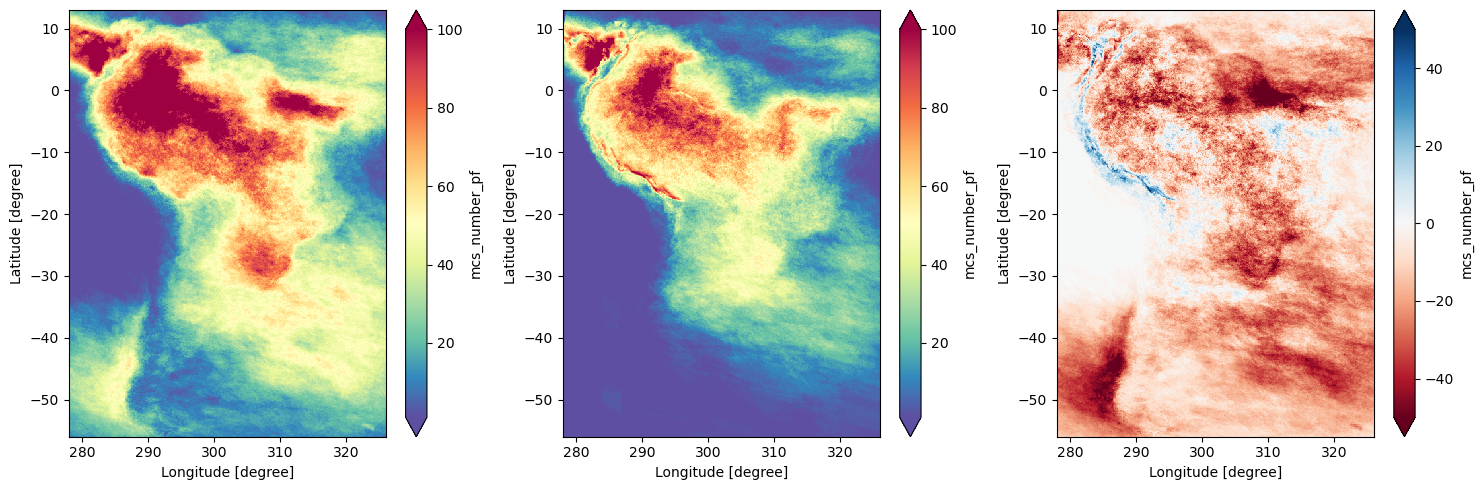

In [18]:
# Quick look plot
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
mcs_number_pf_all_gpm.plot(vmin=1, vmax=100, cmap='Spectral_r', ax=ax[0])
mcs_number_pf_all_wrf.plot(vmin=1, vmax=100, cmap='Spectral_r', ax=ax[1])
mcs_number_pf_all_diff.plot(vmin=-50, vmax=50, cmap='RdBu', ax=ax[2])
fig.tight_layout()

In [19]:
# mcspcp_all_wrf.plot(vmin=0, vmax=12, cmap=cc.cm.rainbow_bgyrm_35_85_c71)

# Plotting Function

In [20]:
def plot_map_3panels(dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-82, -34, -56, 13]
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=[14,5.5], dpi=100)
    # Loop over each panel
    for pp in range(0,3):
        ax = plt.subplot(1, 3, pp+1, projection=proj)
        # Set map projection
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Set up grid lines and labels
        gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
        gl.right_labels = False
        gl.top_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()        
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        if (pp > 0):
            gl.left_labels = False

        # Plot title
        ax.set_title(titles[pp], loc='left')
        data = dataarray[pp]
        # Mask invalid data
#         Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        Zm = np.ma.masked_where(((np.isnan(data))), data)
        # Normalize colormap by discrete levels
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[pp]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
        # Set out-of-bounds colors
        if (oob_colors is not None) and (pp != 2):
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))
        # Plot colorbar
        cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[pp], pad=0.02, ticks=cbticks[pp], extend='both', aspect=30)

        # # Terrain height
        # ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
        #                 colors='dimgray', linewidths=1, transform=proj, zorder=3)

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [21]:
years = f'{start_year}-{end_year}'
years

'2018-2019'

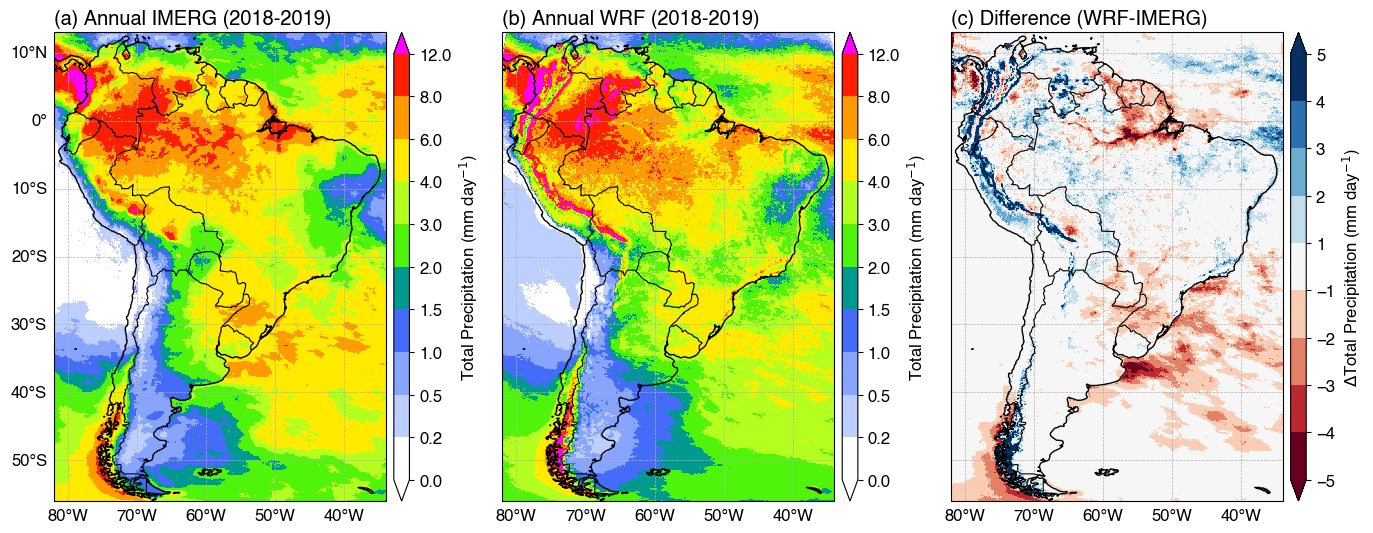

In [22]:
dataarray = [totpcp_all_gpm, totpcp_all_wrf, totpcp_all_diff]
levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
levelsdiff = np.arange(-5,5.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levelspcp, levelspcp, levelsdiff]
cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmaps = [cmappcp,cmappcp,'RdBu']
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['Total Precipitation (mm day$^{-1}$)','Total Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Total Precipitation (mm day$^{-1}$)']
cbticks = levels
figname = f'{figdir}imerg_wrf_total_rainmap_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

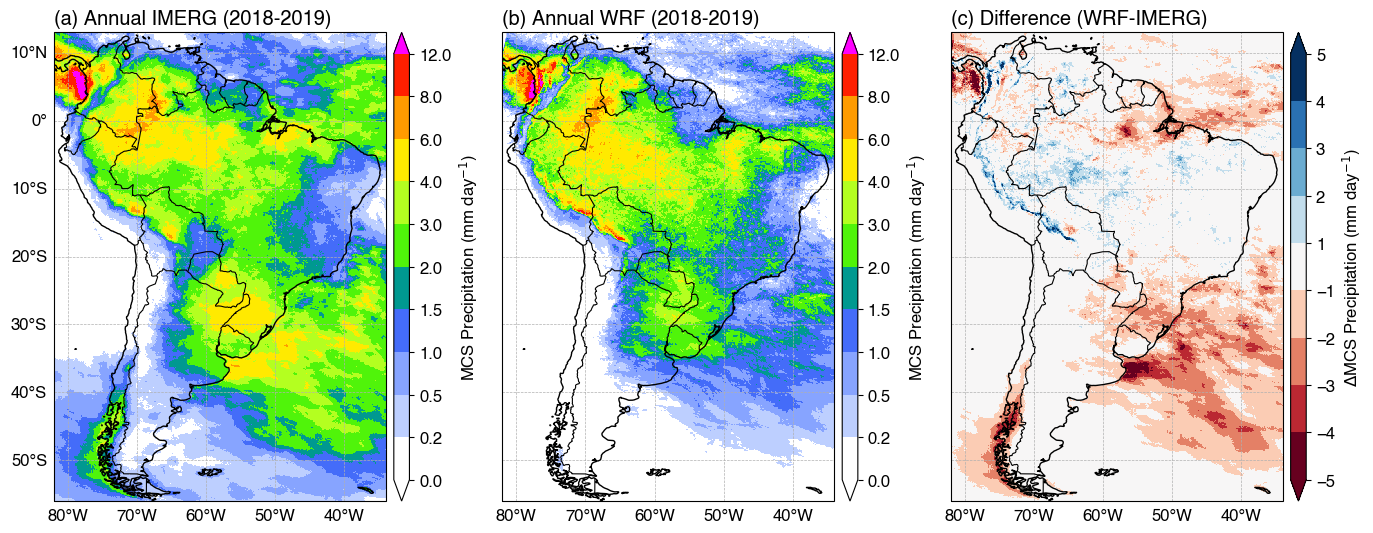

In [23]:
dataarray = [mcspcp_all_gpm, mcspcp_all_wrf, mcspcp_all_diff]
levelspcp = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
levelsdiff = np.arange(-5,5.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levelspcp, levelspcp, levelsdiff]
cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmaps = [cmappcp,cmappcp,'RdBu']
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['MCS Precipitation (mm day$^{-1}$)','MCS Precipitation (mm day$^{-1}$)',r'$\Delta$'+'MCS Precipitation (mm day$^{-1}$)']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_rainmap_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

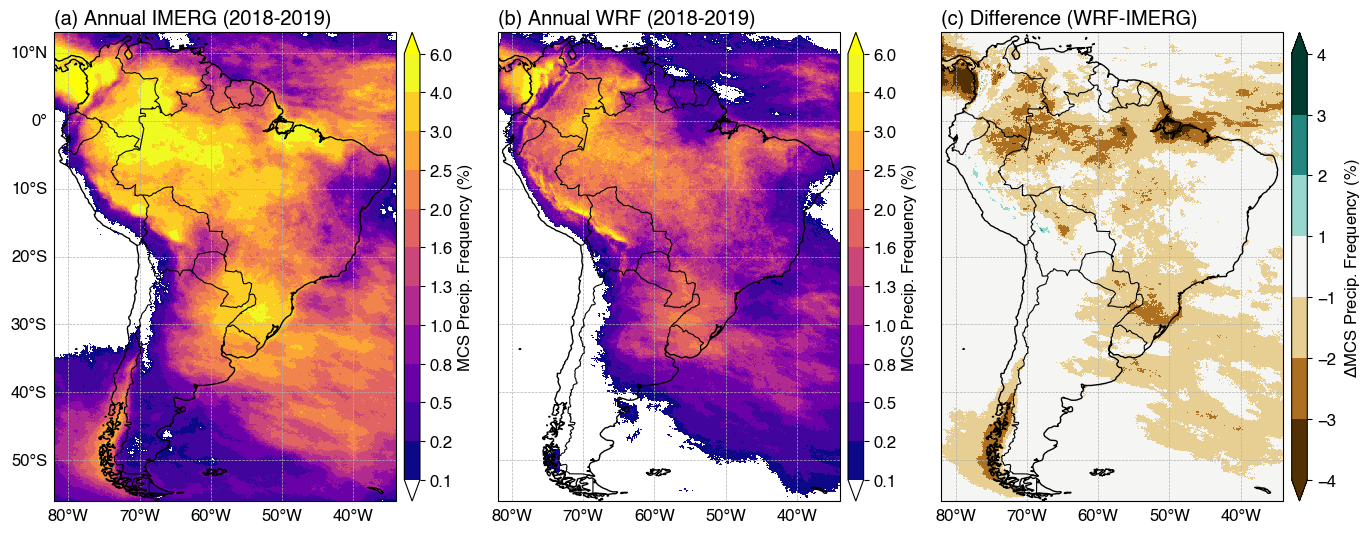

In [24]:
mcspcpfreq_all_diff = mcspcpfreq_all_wrf - mcspcpfreq_all_gpm
dataarray = [mcspcpfreq_all_gpm, mcspcpfreq_all_wrf, mcspcpfreq_all_diff]
levelsfreq = [0.1,0.2,0.5,0.8,1,1.3,1.6,2,2.5,3,4,6]
levelsdiff = np.arange(-4,4.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levelsfreq, levelsfreq, levelsdiff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapfreq = 'plasma'
cmaps = [cmapfreq,cmapfreq,'BrBG']
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['MCS Precip. Frequency (%)','MCS Precip. Frequency (%)',r'$\Delta$'+'MCS Precip. Frequency (%)']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_rainfreq_annual_{years}.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

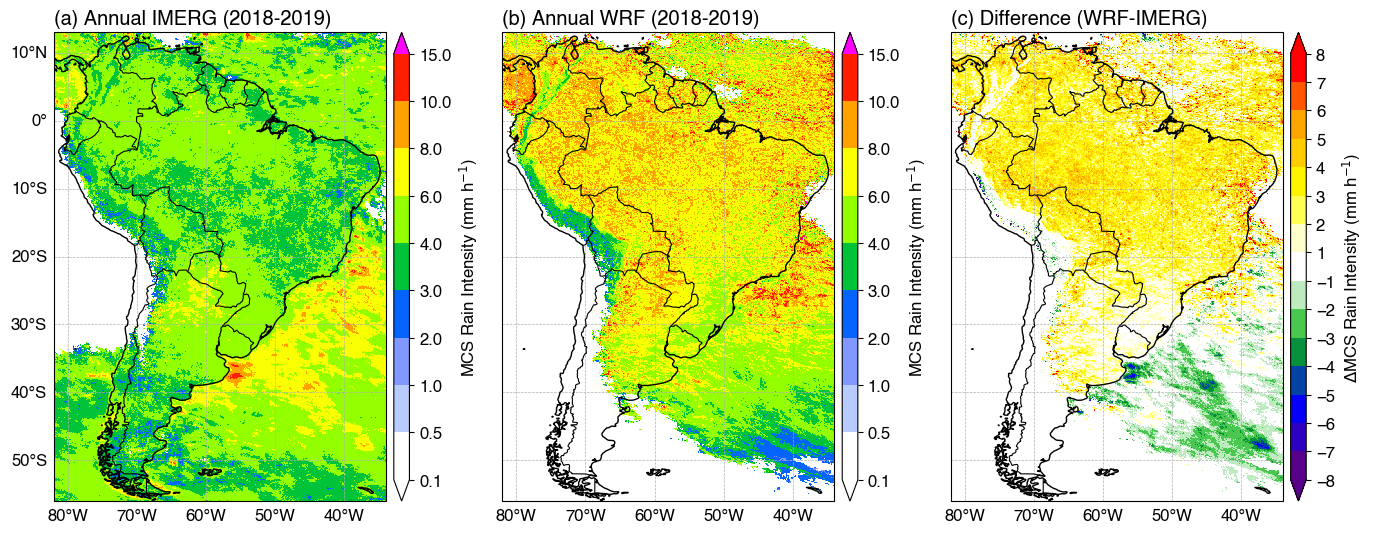

In [25]:
min_nmcs = 3
mcspcpintensity_all_diff = mcspcpintensity_all_wrf - mcspcpintensity_all_gpm
dataarray = [mcspcpintensity_all_gpm.where(mcs_number_pf_all_gpm > min_nmcs), 
             mcspcpintensity_all_wrf.where(mcs_number_pf_all_wrf > min_nmcs),
             mcspcpintensity_all_diff.where(mcs_number_pf_all_wrf > min_nmcs)]
levelspcp = [0.1,0.5,1,2,3,4,6,8,10,15]
levelsdiff = np.arange(-8,8.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levelspcp, levelspcp, levelsdiff]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmapfreq = 'plasma'
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['MCS Rain Intensity (mm h$^{-1}$)','MCS Rain Intensity (mm h$^{-1}$)',r'$\Delta$'+'MCS Rain Intensity (mm h$^{-1}$)']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_rainintensity_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

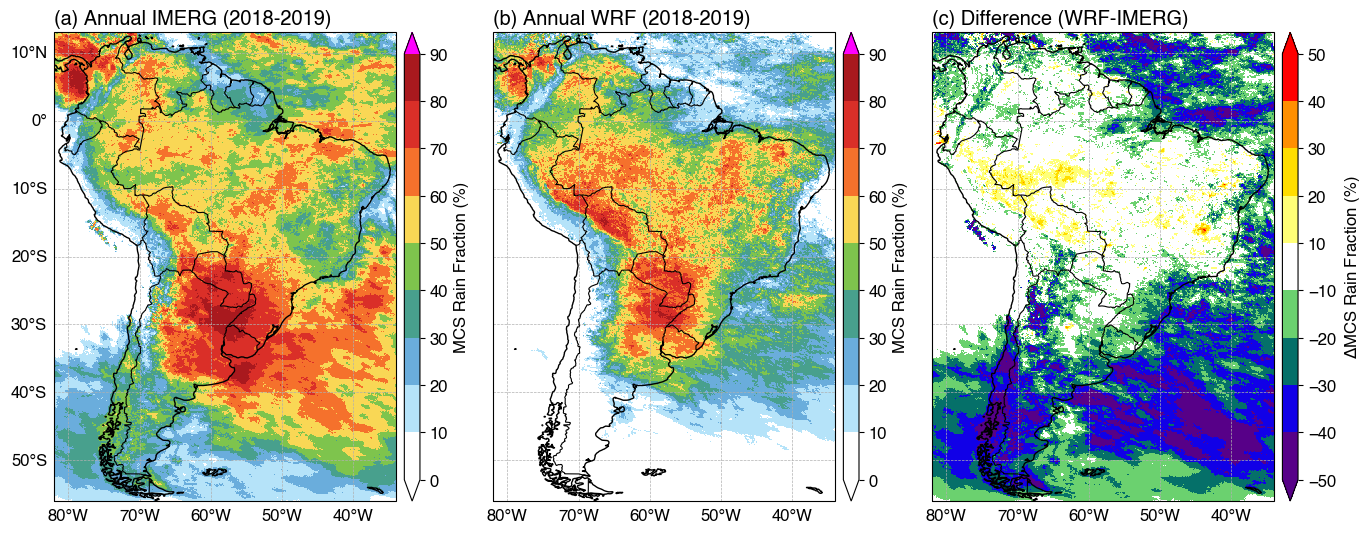

In [26]:
mcspcpfrac_all_diff = mcspcpfrac_all_wrf - mcspcpfrac_all_gpm
dataarray = [mcspcpfrac_all_gpm, mcspcpfrac_all_wrf, mcspcpfrac_all_diff]
levelsfrac = np.arange(0,91,10)
levelsdiff = np.arange(-50,50.1,10)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levelsfrac, levelsfrac, levelsdiff]
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['MCS Rain Fraction (%)','MCS Rain Fraction (%)',r'$\Delta$'+'MCS Rain Fraction (%)']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_rainfrac_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

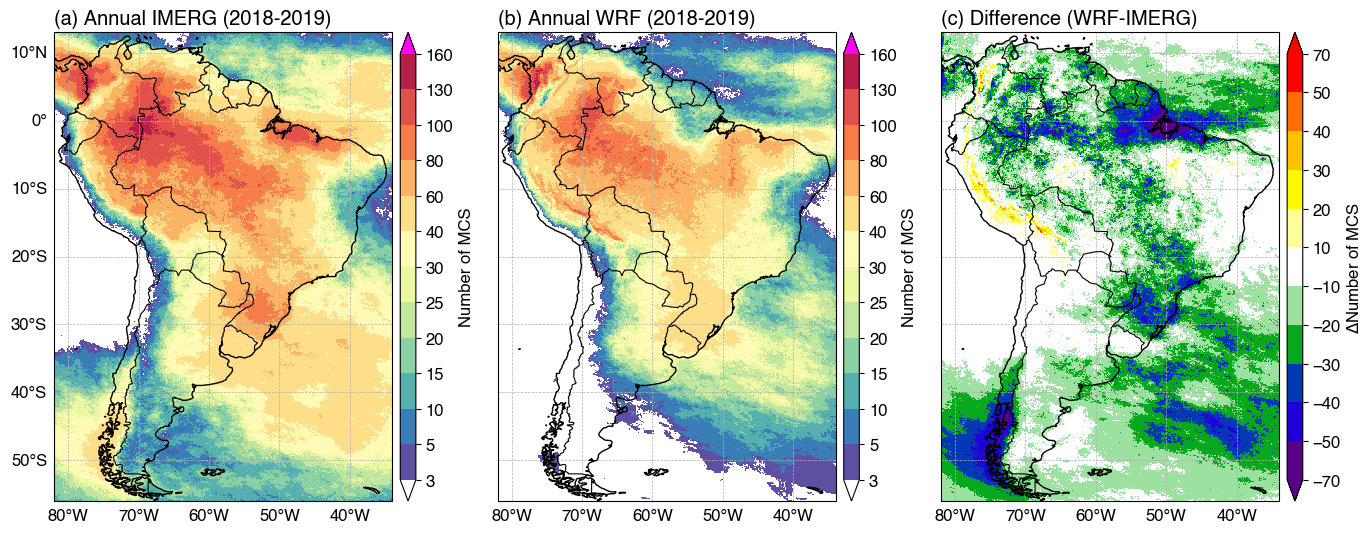

In [27]:
mcs_number_pf_all_diff = mcs_number_pf_all_wrf - mcs_number_pf_all_gpm
dataarray = [mcs_number_pf_all_gpm, mcs_number_pf_all_wrf, mcs_number_pf_all_diff]
levels = [3,5,10,15,20,25,30,40,60,80,100,130,160]
levelsdiff = [-70,-50,-40,-30,-20,-10,10,20,30,40,50,70]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_number_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

# Plot seasonal means to files (does not show in Notebook)

In [28]:
# Plot seasonal MCS rainmap
for ii in seasons:
    mcspcp_season_diff = mcspcp_season_wrf - mcspcp_season_gpm
    dataarray = [mcspcp_season_gpm.sel(season=ii), mcspcp_season_wrf.sel(season=ii), mcspcp_season_diff.sel(season=ii)]
    levels = [0,0.2,0.5,1,1.5,2,3,4,6,8,12]
    levelsdiff = np.arange(-5,5.1,1)
    # Remove mid-point (0 value)
    idx = int((len(levelsdiff)-1)/2)
    levelsdiff = np.delete(levelsdiff, idx)
    levels = [levels, levels, levelsdiff]
    cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
    cmaps = [cmap,cmap,'BrBG']
    titles = [f'(a) {ii} IMERG ({years})', f'(b) {ii} WRF ({years})', f'(c) {ii} Difference (WRF-IMERG)']
    cblabels = ['MCS Precipitation (mm day$^{-1}$)','MCS Precipitation (mm day$^{-1}$)',r'$\Delta$'+'MCS Precipitation (mm day$^{-1}$)']
    cbticks = levels
    figname = f'{figdir}imerg_wrf_mcs_rainmap_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
    plt.close(fig)
    print(f'{ii}: {figname}')

DJF: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainmap_DJF_2018-2019.png
JJA: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainmap_JJA_2018-2019.png
MAM: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainmap_MAM_2018-2019.png
SON: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainmap_SON_2018-2019.png


In [29]:
for ii in seasons:
    mcspcpfreq_season_diff = mcspcpfreq_season_wrf - mcspcpfreq_season_gpm
    dataarray = [mcspcpfreq_season_gpm.sel(season=ii), mcspcpfreq_season_wrf.sel(season=ii), mcspcpfreq_season_diff.sel(season=ii)]
    levelsfreq = [0.2,0.5,0.8,1,1.3,1.6,2,2.5,3,4,6,8]
    levelsdiff = np.arange(-5,5.1,1)
    # Remove mid-point (0 value)
    idx = int((len(levelsdiff)-1)/2)
    levelsdiff = np.delete(levelsdiff, idx)
    levels = [levelsfreq, levelsfreq, levelsdiff]
    cmapfreq = 'plasma'
    cmaps = [cmapfreq,cmapfreq,'BrBG']
    titles = [f'(a) {ii} IMERG ({years})', f'(b) {ii} WRF ({years})', f'(c) {ii} Difference (WRF-IMERG)']
    cblabels = ['MCS Precip. Frequency (%)','MCS Precip. Frequency (%)',r'$\Delta$'+'MCS Precip. Frequency (%)']
    cbticks = levels
    figname = f'{figdir}imerg_wrf_mcs_rainfreq_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'yellow'}
    fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
    plt.close(fig)
    print(f'{ii}: {figname}')

DJF: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfreq_DJF_2018-2019.png
JJA: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfreq_JJA_2018-2019.png
MAM: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfreq_MAM_2018-2019.png
SON: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfreq_SON_2018-2019.png


In [30]:
for ii in seasons:
    min_nmcs = 2
    mcspcpintensity_season_diff = mcspcpintensity_season_wrf - mcspcpintensity_season_gpm
    dataarray = [mcspcpintensity_season_gpm.sel(season=ii).where(mcs_number_pf_season_gpm.sel(season=ii) > min_nmcs), 
                 mcspcpintensity_season_wrf.sel(season=ii).where(mcs_number_pf_season_wrf.sel(season=ii) > min_nmcs),
                 mcspcpintensity_season_diff.sel(season=ii).where(mcs_number_pf_season_wrf.sel(season=ii) > min_nmcs)]
    levelspcp = [0.1,0.5,1,2,3,4,6,8,10,15]
    levelsdiff = np.arange(-8,8.1,1)
    # Remove mid-point (0 value)
    idx = int((len(levelsdiff)-1)/2)
    levelsdiff = np.delete(levelsdiff, idx)
    levels = [levelspcp, levelspcp, levelsdiff]
    cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
    cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
    cmaps = [cmap,cmap,cmapdiff]
    titles = [f'(a) {ii} IMERG ({years})', f'(b) {ii} WRF ({years})', f'(c) {ii} Difference (WRF-IMERG)']
    cblabels = ['MCS Rain Intensity (mm h$^{-1}$)','MCS Rain Intensity (mm h$^{-1}$)',r'$\Delta$'+'MCS Rain Intensity (mm h$^{-1}$)']
    cbticks = levels
    figname = f'{figdir}imerg_wrf_mcs_rainintensity_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
    plt.close(fig)
    print(f'{ii}: {figname}')

DJF: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainintensity_DJF_2018-2019.png
JJA: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainintensity_JJA_2018-2019.png
MAM: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainintensity_MAM_2018-2019.png
SON: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainintensity_SON_2018-2019.png


In [31]:
for ii in seasons:
    mcspcpfrac_season_diff = mcspcpfrac_season_wrf - mcspcpfrac_season_gpm
    dataarray = [mcspcpfrac_season_gpm.sel(season=ii), mcspcpfrac_season_wrf.sel(season=ii), mcspcpfrac_season_diff.sel(season=ii)]
    levelsfrac = np.arange(0,91,10)
    levelsdiff = np.arange(-50,50.1,10)
    # Remove mid-point (0 value)
    idx = int((len(levelsdiff)-1)/2)
    levelsdiff = np.delete(levelsdiff, idx)
    levels = [levelsfrac, levelsfrac, levelsdiff]
    cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
    cmap = truncate_colormap(cmap, 0.0, 0.95)
    cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
    cmaps = [cmap,cmap,cmapdiff]
    titles = [f'(a) {ii} IMERG ({years})', f'(b) {ii} WRF ({years})', f'(c) {ii} Difference (WRF-IMERG)']
    cblabels = ['MCS Rain Fraction (%)','MCS Rain Fraction (%)',r'$\Delta$'+'MCS Rain Fraction (%)']
    cbticks = levels
    figname = f'{figdir}imerg_wrf_mcs_rainfrac_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
    plt.close(fig)
    print(f'{ii}: {figname}')

DJF: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfrac_DJF_2018-2019.png
JJA: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfrac_JJA_2018-2019.png
MAM: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfrac_MAM_2018-2019.png
SON: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_rainfrac_SON_2018-2019.png


In [32]:
for ii in seasons:
    mcs_number_pf_season_diff = mcs_number_pf_season_wrf - mcs_number_pf_season_gpm
    dataarray = [mcs_number_pf_season_gpm.sel(season=ii), mcs_number_pf_season_wrf.sel(season=ii), mcs_number_pf_season_diff.sel(season=ii)]
    levels = [2,4,7,10,13,16,20,25,30,35,40]
    levelsdiff = [-30,-20,-15,-10,-5,5,10,15,20,30]
    levels = [levels, levels, levelsdiff]
    cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
    cmap = truncate_colormap(cmap, 0.0, 0.95)
    cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
    cmaps = [cmap,cmap,cmapdiff]
    titles = [f'(a) {ii} IMERG ({years})', f'(b) {ii} WRF ({years})', f'(c) {ii} Difference (WRF-IMERG)']
    cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
    cbticks = levels
    figname = f'{figdir}imerg_wrf_mcs_number_{ii}_{years}.png'
    oob_colors = {'under':'white', 'over':'magenta'}
    fig = plot_map_3panels(dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)
    plt.close(fig)
    print(f'{ii}: {figname}')

DJF: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_number_DJF_2018-2019.png
JJA: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_number_JJA_2018-2019.png
MAM: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_number_MAM_2018-2019.png
SON: /global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/imerg_wrf_mcs_number_SON_2018-2019.png


In [33]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'